### Imports

In [6]:
import pickle
import numpy as np
import pandas as pd
from glob import glob
from os.path import basename, dirname, isdir, isfile, join
from tqdm import tqdm_notebook as tqdm

import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate

### Split data

<div hidden>
# root = "/Volumes/hd_4tb/results/training/*/*"
# dfs = list()
# for folder in tqdm(glob(root)):
#     df = pd.read_csv(join(folder, "simple.csv"))
#     df["pred"] = np.load(join(folder, "pred.npy"))
#     dfs.append(df)
    
# df = pd.concat(dfs)
</div>

In [7]:
df = pd.read_feather("/Users/pstetz/Desktop/confidential/.project/summary/simple_all.feather")
df = df.sample(frac=1)
df = df.reset_index(drop=True)
train_x, test_x = train_test_split(df, random_state=5, train_size=0.80)
del df
train_y = train_x.pop("pred")
test_y = test_x.pop("pred")

### Put data into chunks

In [3]:
# N = 1000
# train_x = np.array_split(train_x, N)
# train_y = np.array_split(train_y, N)

### Training

run 1
```
'param_grid': {
    'learning_rate': [0.01, 0.1, 1],
    'num_leaves': [30, 55, 85],
    'min_split_gain': [0.05, 0.3],
    'min_data_in_leaf': [40, 100]
}

{'learning_rate': 0.1, 'min_data_in_leaf': 100, 'min_split_gain': 0.3, 'num_leaves': 85}
```

run 2
```
params = {
    "learning_rate": [0.1, 0.3],
    "num_leaves": [70, 85, 100],
    "min_split_gain": [0.25, 0.3, 0.35],
    "min_data_in_leaf": [80, 100, 120, 150]
    "n_estimators": [80, 100, 125]
}

0.6304165320899651
{'learning_rate': 0.1, 'min_data_in_leaf': 80, 'min_split_gain': 0.3, 'n_estimators': 125, 'num_leaves': 85}
```

In [4]:
params = {
#     "num_iteration": [3000, 4000, 4500],
#     'max_depth': [5, 7, 15], 
#     'reg_alpha': [0, 0.1], 'reg_lambda': [0.1, 1], 
#     "min_split_gain": [0.25, 0.3, 0.35], "min_data_in_leaf": [80, 100, 120, 150], #'min_child_weight': 4,
#     "n_estimators": [80, 100, 125] #, "feature_fraction": 0.5
}
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
model = lgb.LGBMRegressor(
    boosting_type="gbdt",
    objective="mse",
    learning_rate=0.1,
    min_data_in_leaf=80,
    min_split_gain=0.3,
    n_estimators=125,
    num_leaves=85,
    max_depth=-1,
)
gs = GridSearchCV(model, param_grid=params, cv=5, verbose=10, scoring=mse_scorer)
gs.fit(train_x, train_y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  7.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001,
                                     min_data_in_leaf=80, min_split_gain=0.3,
                                     n_estimators=125, n_jobs=-1, num_leaves=85,
                                     objective='mse', random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [5, 7, 15]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=F

### Cross validate

In [ ]:
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
model = lgb.LGBMRegressor(
    boosting_type="gbdt",
    objective="mse",
    learning_rate=0.1,
    min_data_in_leaf=80,
    min_split_gain=0.3,
    n_estimators=125,
    num_leaves=85,
    max_depth=-1,
)

cross_validate(model, train_x, train_y, cv=5, scoring=mse_scorer)

### Save model

In [ ]:
model_filepath = "/Users/pstetz/Desktop/confidential/.project/run/lgbm/1_lgbm.pkl"
with open(model_filepath, 'wb') as f:
    pickle.dump(model, f)

### Score

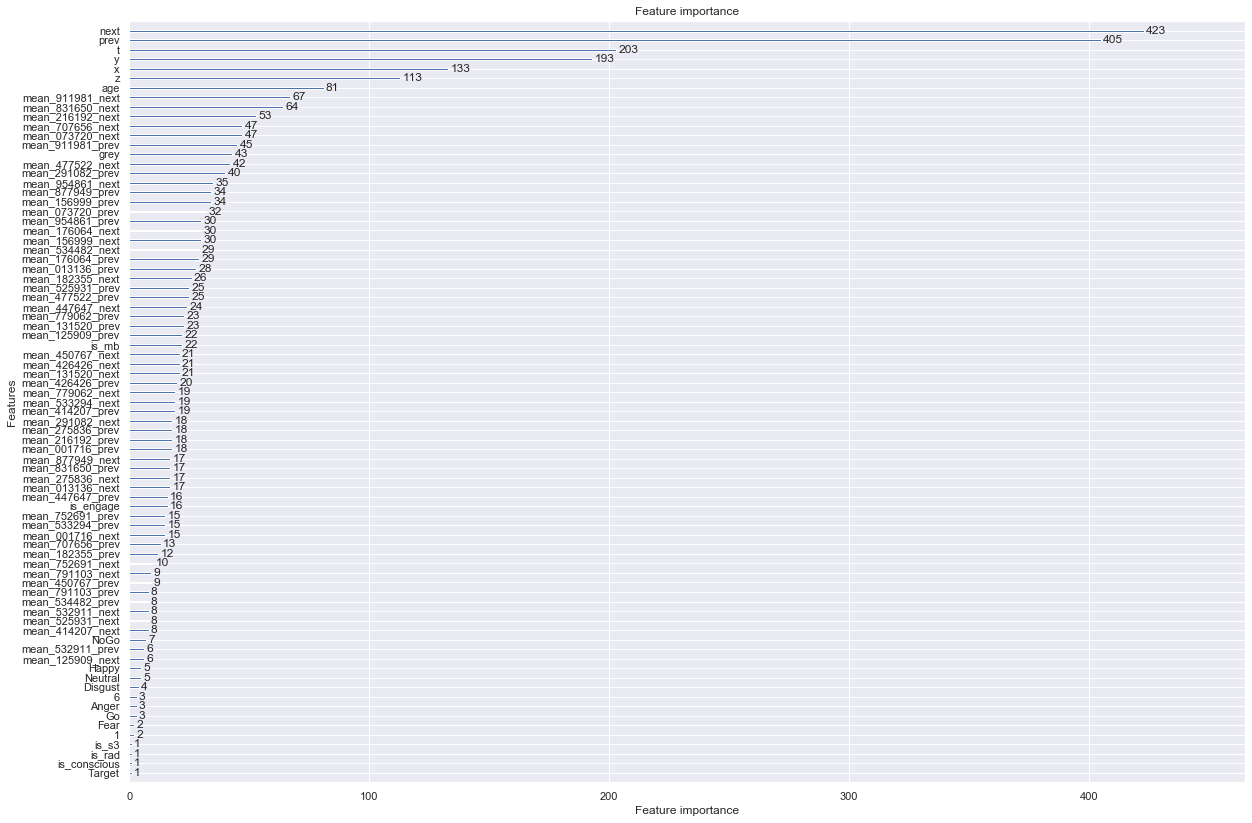

In [18]:
fig, ax = plt.subplots(figsize=(20, 14))
lgb.plot_importance(model, ax=ax);

0.6363080481730099


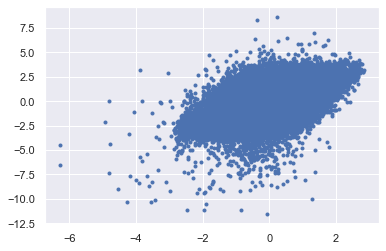

In [14]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

expected = model.predict(test_x)
score = mean_squared_error(test_y, expected)
print(score)
plt.plot(expected, test_y, ".");

In [15]:
model.feature_importances_

array([  3,   1,   3,   4,   5,   2,   5,   0,   7,   0,   3,   2,   0,
         0,   0,   0,   0,   0,   1,   0,   0,  16,   0,   0,   0,   0,
        22,   0,   0,   0,   0,   0,   0,   1,   0,   0,   1,   0,   0,
         0,   0,  81,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  15,  18,  17,  28,  47,  32,   6,  22,
        21,  23,  30,  34,  30,  29,  26,  12,  53,  18,  17,  18,  18,
        40,   8,  19,  21,  20,  24,  16,  21,   9,  42,  25,   8,  25,
         8,   6,  19,  15,  29,   8,  47,  13,  10,  15,  19,  23,   9,
         8,  64,  17,  17,  34,  67,  45,  35,  30, 203, 133, 193, 113,
       405, 423,  43], dtype=int32)